# Sparse PCA

[sklearn.decomposition.SparsePCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)

Principal component analysis (PCA) has the disadvantage that the components extracted by this method have exclusively dense expressions, i.e. they have non-zero coefficients when expressed as linear combinations of the original variables. This can make interpretation difficult. In many cases, the real underlying components can be more naturally imagined as sparse vectors; for example in face recognition, components might naturally map to parts of faces.

Sparse principal components yields a more parsimonious, interpretable representation, clearly emphasizing which of the original features contribute to the differences between samples.

Usable examples: [Faces dataset decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
from skimage import io
import matplotlib.pylab as plt
import notebooks.notebook_utils as uts

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## load datset

loading dataset: (True) exists -> /mnt/30C0201EC01FE8BC/TEMP/atomicPatternDictionary_v0/datasetFuzzy_raw
loading (True) <- /mnt/30C0201EC01FE8BC/TEMP/atomicPatternDictionary_v0/dictionary/atlas.png


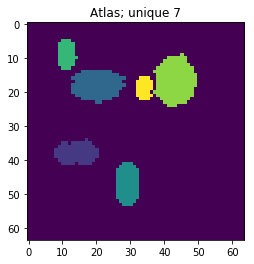

In [2]:
p_dataset = os.path.join(uts.DEFAULT_PATH, uts.SYNTH_DATASETS_FUZZY[0])
print ('loading dataset: ({}) exists -> {}'.format(os.path.exists(p_dataset), p_dataset))

p_atlas = os.path.join(uts.DEFAULT_PATH, 'dictionary/atlas.png')
atlas_gt = io.imread(p_atlas)
nb_patterns = len(np.unique(atlas_gt))
print ('loading ({}) <- {}'.format(os.path.exists(p_atlas), p_atlas))
plt.imshow(atlas_gt, interpolation='nearest')
_ = plt.title('Atlas; unique %i' % nb_patterns)

In [3]:
list_imgs = uts.load_dataset(p_dataset)
print ('loaded # images: ', len(list_imgs))
img_shape = list_imgs[0].shape
print ('image shape:', img_shape)

loaded # images:  800
image shape: (64, 64)


## Pre-Processing

input data shape: (800, 4096)


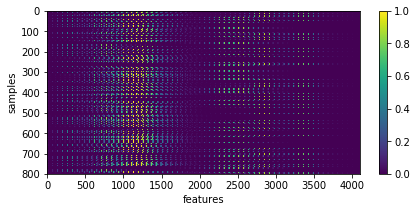

In [13]:
X = np.array([im.ravel() for im in list_imgs])  # - 0.5
print ('input data shape:', X.shape)

plt.figure(figsize=(7, 3))
_= plt.imshow(X, aspect='auto'), plt.xlabel('features'), plt.ylabel('samples'), plt.colorbar()

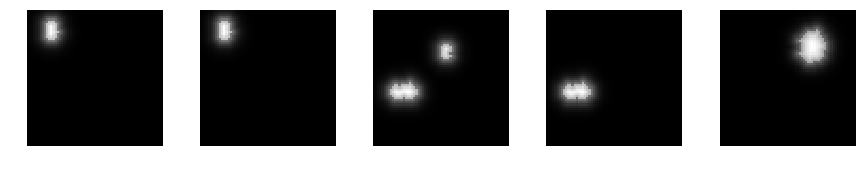

In [5]:
uts.show_sample_data_as_imgs(X, img_shape, nb_rows=1, nb_cols=5)

## SparsePCA

In [6]:
from sklearn.decomposition import SparsePCA
spca = SparsePCA(n_components=nb_patterns, max_iter=999, n_jobs=-1)

X_new = spca.fit_transform(X[:1200,:])
print ('fitting parameters:', spca.get_params())
print ('number of iteration:', spca.n_iter_)

fitting parameters: {'n_jobs': -1, 'verbose': False, 'ridge_alpha': 0.01, 'max_iter': 999, 'V_init': None, 'U_init': None, 'random_state': None, 'n_components': 7, 'tol': 1e-08, 'alpha': 1, 'method': 'lars'}
number of iteration: 46


**show the estimated components - dictionary**

estimated component matrix: (7, 4096)


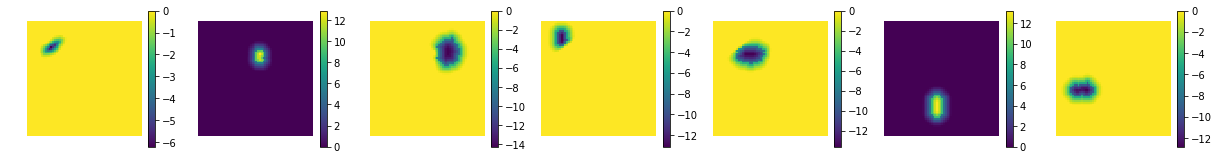

In [7]:
comp = spca.components_
coefs = np.sum(np.abs(X_new), axis=0)
# print 'used coeficients:', coefs.tolist()
print ('estimated component matrix:', comp.shape)

compSorted = [c[0] for c in sorted(zip(comp, coefs), key=lambda x: x[1], reverse=True) ]
uts.show_sample_data_as_imgs(np.array(compSorted), img_shape, nb_cols=nb_patterns, bool_clr=True)

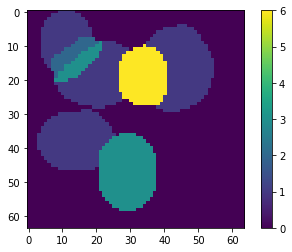

In [8]:
ptn_used = np.sum(np.abs(X_new), axis=0) > 0
atlas_ptns = comp[ptn_used, :].reshape((-1, ) + list_imgs[0].shape)

atlas_ptns = comp.reshape((-1, ) + list_imgs[0].shape)
atlas_estim = np.argmax(atlas_ptns, axis=0) + 1
atlas_sum = np.sum(np.abs(atlas_ptns), axis=0)
atlas_estim[atlas_sum < 1e-1] = 0
_ = plt.imshow(atlas_estim, interpolation='nearest'), plt.colorbar()

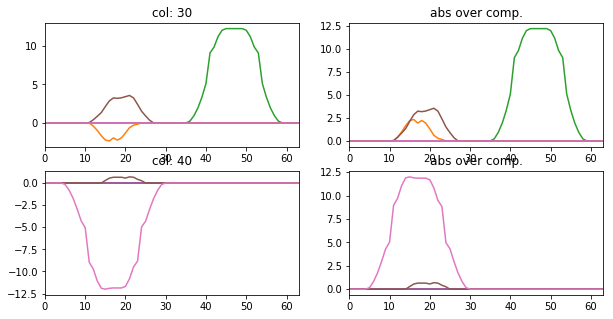

In [9]:
l_idx = [30, 40]
fig, axr = plt.subplots(len(l_idx), 2, figsize=(10, 2.5 * len(l_idx)))
for i, idx in enumerate(l_idx):
    axr[i, 0].plot(atlas_ptns[:,:,idx].T), axr[i, 0].set_xlim([0, 63])
    axr[i, 0].set_title('col: {}'.format(idx))
    axr[i, 1].plot(np.abs(atlas_ptns[:,:,idx].T)), axr[i, 1].set_xlim([0, 63])
    axr[i, 1].set_title('abs over comp.')

**particular coding of each sample**

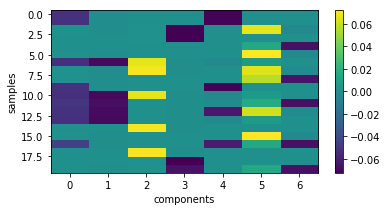

In [10]:
plt.figure(figsize=(6, 3))
plt.imshow(X_new[:20,:], interpolation='nearest', aspect='auto'), plt.colorbar()
_= plt.xlabel('components'), plt.ylabel('samples')

**backword reconstruction from encoding and dictionary**

In [11]:
res = np.dot(X_new, comp)
print ('model applies by reverting the unmixing', res.shape)

model applies by reverting the unmixing (800, 4096)


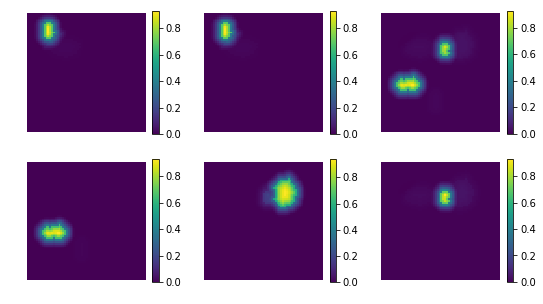

In [15]:
uts.show_sample_data_as_imgs(res, img_shape, nb_rows=2, nb_cols=3, bool_clr=True)